# Customizing contact map plots

The main plotting methods use matplotlib. If you're already familiar with matplotlib, you'll have a good background already. If not, what you learn about Contact Map Explorer will transfer to other projects.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")

In [2]:
from contact_map import ContactFrequency
traj_contacts = ContactFrequency(traj)
frame_contacts = ContactFrequency(traj[0])
diff = traj_contacts - frame_contacts

## Putting multiple plots in one figure

You may want to plot multiple maps in one figure. This can easily be done by using the `plot_axes` method, which acts just like `plot` except that it requires that you give it a Matplotlib `Axes` object to plot into.

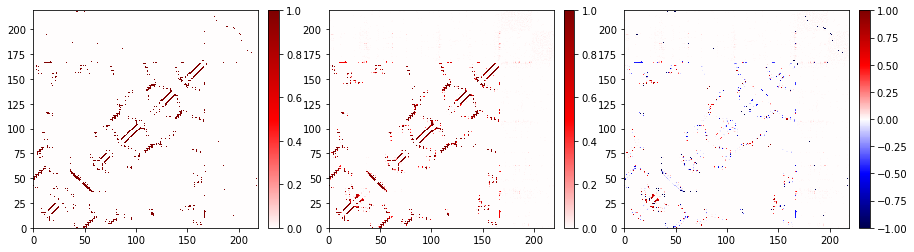

In [3]:
# Make a subplot with 1 row but three columns and a bigger figsize
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Flatten the axis to a list
axs = axs.flatten()

# Make a list of the contact objects we want to plot in this case: frame, trajectory, 
# difference
contacts = [frame_contacts, traj_contacts, diff]

# Now loop and make the plot
for ax, contact in zip(axs, contacts):
    contact.residue_contacts.plot_axes(ax=ax)

## Changing the color map

You can use any Matplotlib color map, see the [Matplotlib documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for details. In general, the color schemes that you are likely to use with Contact Map Explorer are either "diverging" or "sequential." Diverging color maps are useful when looking at contact differences. The default color map is `seismic`, which is a diverging contact map.

Contact Map Explorer has some extra tricks to make it so that the same color map works for either contact frequencies or contact differences: if given a diverging map, and if there are no negative values in the data, Contact Map Explorer will only use the upper half of the contact map.

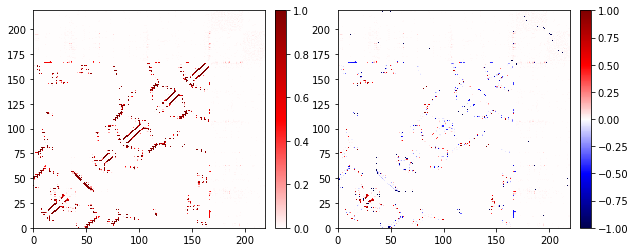

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
traj_contacts.residue_contacts.plot_axes(ax=axs[0]);
diff.residue_contacts.plot_axes(ax=axs[1]);

Note that you're using the same color map in both, but when there's no negative data, we only use the upper half. We can do the same with any diverging color map; next we'll use the purple-green diverging map `PRGn`.

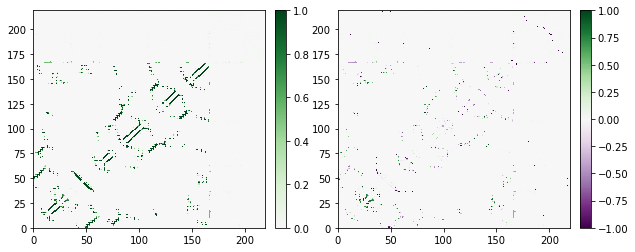

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
traj_contacts.residue_contacts.plot_axes(ax=axs[0], cmap='PRGn');
diff.residue_contacts.plot_axes(ax=axs[1], cmap='PRGn');

If you want to use a sequential map, use `vmin=0`.

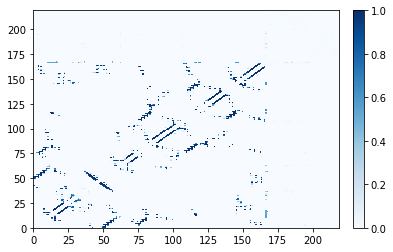

In [6]:
traj_contacts.residue_contacts.plot(cmap="Blues", vmin=0);

## Common matplotlib customizations

In this section, we'll show several matplotlib tricks that are frequently useful. None of this is specific to Contact Map Explorer; these are all just directly using matplotlib to achieve common goals. Overall, the limits here are the limits of matplotlib -- which is to say not many, but it isn't always obvious how to do it.

Be aware that each contact is plotted as a 1-by-1 rectangle with lower limit at the index of the residue. That is to say, a contact between residue 0 on the x-axis and residue 15 on the y-axis is a box between lower-left coordinate (0, 15) and upper-right coordinate (1, 16). Especially important: plotted residue locations are based on residue index. This means:

* The first residue plots between 0 and 1. The can cause confusion when thinking about PDB sequences, which start at residue 1.
* If there is a gap in residue sequences, this gap does not appear in the plot. For example, if you had a system that only included PDB residue numbers `1, 2, 7, 8`, these would show up on the plot with lower edges at `0, 1, 2, 3`, respectively.
* This does not apply to atoms/residues that are not included in the `query` or `haystack` of your system. The plotting is based on the numbering in the topology from the MDTraj trajectory you load into Contact Map Explorer.

### A quick conceptual introduction to matplotlib

The main objects you may deal with in matplotlib are `Figure`s (`fig`) and `Axes` (`ax`). A `Figure` is the whole plot; this may include multiple "subplots" with different contact maps (see examples above). An `Axes` is the rectangular region you're plotting in. The color bar is actually a second `Axes` in our `Figure`.

Our main plotting function follows the behavior of other matplotlib plotting functions in returning the `Figure` and the main `Axes`, i.e., the `Axes` object with the contact map. That `Axes` object has many methods that allow you to further customize the plot.

Many of those functions can also be accessed through the `matplotlib.pyplot` interface, which unifies the `Figure` and `Axes`. The `pyplot` interface was designed to be easy for beginners to use, but it is much less flexible than directly interacting with the `Figure` and `Axes`.

### Changing the range of the plot

(166.0, 167.0)

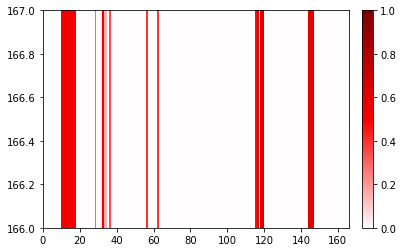

In [7]:
fig, ax = traj_contacts.residue_contacts.plot()
ax.set_xlim(0, 166)
ax.set_ylim(166, 167)
# also available as plt.xlim(0, 166); plt.ylim(166, 167)

### Customizing the axes labels and tick marks

It's easy to label your axes. By default, we do not label axes because the shift by one (due to PDB counts starting at 1) and the possibility of gaps in the residue sequence could lead to misinterpretation.

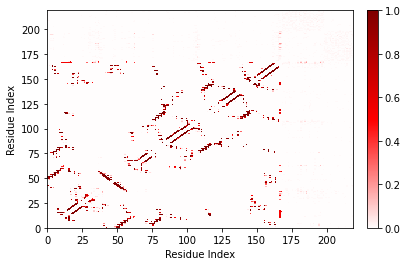

In [8]:
fig, ax = traj_contacts.residue_contacts.plot()
ax.set_xlabel('Residue Index')
ax.set_ylabel('Residue Index');
# also available as plt.xlabel; plt.ylabel

Matplotlib allows a great deal of customization in how the axes are presented. Here I'll make it so that GTP is labeled as "GTP" instead of as a number.

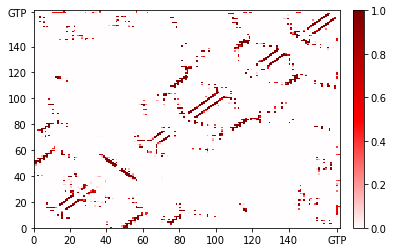

In [9]:
fig, ax = traj_contacts.residue_contacts.plot()
ticklocations = [0, 20, 40, 60, 80, 100, 120, 140, 166.5]
ticklabels = ['0', '20', '40', '60', '80', '100', '120', '140', 'GTP']
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_ticks(ticklocations)
    axis.set_ticklabels(ticklabels)

ax.set_xlim(0, 168)
ax.set_ylim(0, 168);

### Adding lines to guide the eye

Let's say we wanted to add a line to separate the protein (residues 0 to 165) from the GTP (residue 166) and the ions. We can do this with matplotlib's `axvline` and `axhline` to create vertical and horizontal lines, respectively.

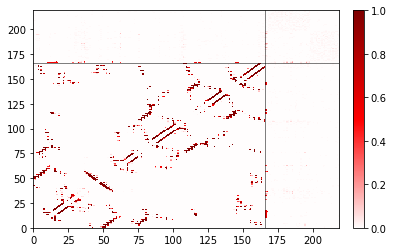

In [10]:
fig, ax = traj_contacts.residue_contacts.plot()
# color='k' is black; lw=0.5 sets line width
ax.axvline(166, color='k', lw=0.5)
ax.axhline(166, color='k', lw=0.5)
# also available as plt.axvline, plt.axhline

### Changing attributes of the colorbar

The `ax` we return is the same as `fig.axes[0]`. To get to the colorbar, use `fig.axes[1]`.

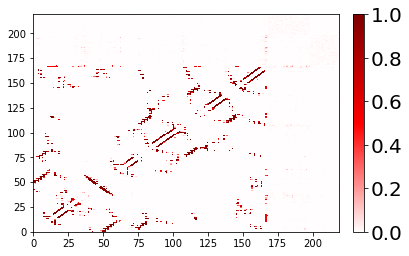

In [11]:
fig, ax = traj_contacts.residue_contacts.plot()
fig.axes[1].yaxis.set_tick_params(labelsize=20)

## Performance when plotting

While `residue_contact.plot()` is obviously a very easy way to make a plot, you can always convert the contact data to another format and then plot using other tools. For more on various methods to export data, see the notebook on integrations with other tools.

Sometimes different plotting methods will be faster than the built-in version. For example, when the contact matrix is relatively dense, as with the example with a larger cutoff, it can be faster to go by way of exporting to pandas and plotting the DataFrame using `matplotlib.pyplot.pcolor`.

In [12]:
%%time
large_cutoff = ContactFrequency(trajectory=traj[::10], cutoff=1.5)

CPU times: user 18.7 s, sys: 342 ms, total: 19 s
Wall time: 20.6 s


CPU times: user 18.4 s, sys: 347 ms, total: 18.7 s
Wall time: 20.3 s


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

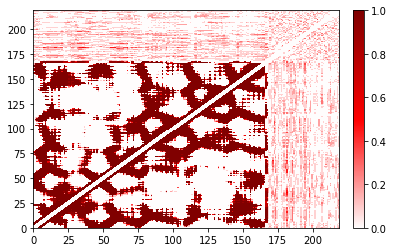

In [13]:
%%time
large_cutoff.residue_contacts.plot();

CPU times: user 2.41 s, sys: 37.5 ms, total: 2.45 s
Wall time: 2.52 s


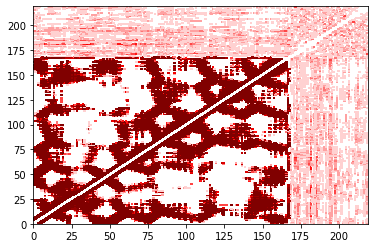

In [14]:
%%time
import matplotlib
import copy
cmap = copy.copy(plt.get_cmap('seismic'))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

plot = plt.pcolor(large_cutoff.residue_contacts.df, cmap=cmap, vmin=-1,
                  vmax=1)
plot.cmap.set_under(cmap(norm(0)));

You'll notice that these may not be pixel-perfect copies. This is because the number of pixels doesn't evenly divide into the number of residues. You can improve this by increasing the resolution (`dpi` in matplotlib) or the figure size. However, in both versions you can see the overall structure quite clearly. In addition, the color bar is only shown in the built-in version.